## Assignment 3: Variational Auto Encoder for Out-of-Distribution Sample Detection


## Exercise 1

Show that the ELBO can alternatively be derived from the KL divergence between the variational distribution $q(z|x)$ and the true posterior distribution  $p(z|x)$:

$$
\mathbb{D}_{KL} \left[ q(\mathbf{z}|\mathbf{x}) \,\|\, p(\mathbf{z}|\mathbf{x}) \right] = 
\int q(\mathbf{z}|\mathbf{x}) \log \left[ \frac{q(\mathbf{z}|\mathbf{x})}{p(\mathbf{z}|\mathbf{x})} \right] d\mathbf{z}.
$$


YOUR ANSWER HERE
![](Images/p1.1.jpg)
![](Images/p1.2.jpg)

# Overview

The out-of-distribution (OOD) data has a significantly different distribution from the training in-distribution (ID) data. Anomaly detection is a technique for identifying abnormal situations and mining nonlogical data. Novelty detection finds novel data in the dataset that may belong to the classification but have not been seen. Outlier detection focuses on data points that are significantly different from other observations. Although the names of these terms are different, the core of their strategy is finding OOD samples. In this assignment reconstruction error will be used to detect out of distributions points.



We will start by implementing a simple auto-encoder (AE) using PyTorch and training it on
the MNIST dataset.



1. Loads the MNIST dataset and splits it into:
  

*   A train dataset (excluding a specific digit, in this case  5, which is treated as the anomaly).

*   A test dataset (excluding a specific digit, in this case 5, which is treated as the anomaly).
*   An anomaly dataset (containing only the excluded digit, that is  5).


2. Defines a VAE model to learn a compressed representation (latent space) of the data.
3. Train the VAE on the train dataset.
4. Evaluates the VAE on the combination of test and anomaly dataset to detect anomalies using reconstruction error 


In [244]:
skip_training = True  # Set this flag to True before validation and submission

## Import Libraries and Functions

In [245]:
import tools, warnings
warnings.showwarning = tools.customwarn

In [246]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [247]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [248]:
from __future__ import print_function
import os
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn import metrics
from scipy import stats

# Anomaly number
ANOMALY_TARGET = 5


## MNIST Data Loader

The MNIST dataset contains images with numbers 0-9. We selected 0-9 as normal numbers except 5 which is set as the anomaly number. The next step is to separate the data accordingly into the normal and anomaly datasets for training and testing:

Train Dataset: Loads the MNIST dataset and excludes the anomaly target (e.g., digit 5).

Anomaly Dataset: Loads only the anomaly target (e.g., digit 5).

DataLoaders: Creates PyTorch DataLoader objects for batching and shuffling the data.

In [249]:
import  tools
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [250]:
# Training dataset excluding anomaly target numbers
train_dataset = tools.MNIST(data_dir, train=True )
train_mask = (train_dataset.mnist.targets != ANOMALY_TARGET)
train_dataset.data = train_dataset.mnist.data[train_mask]
train_dataset.targets = train_dataset.mnist.targets[train_mask]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
all_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [251]:
print("Train dataset shape:", train_dataset.data.shape)
print("Train labels shape:", train_dataset.targets.shape)

Train dataset shape: torch.Size([54579, 28, 28])
Train labels shape: torch.Size([54579])


In [252]:
# Training dataset excluding anomaly target numbers 5
test_dataset = tools.MNIST(data_dir, train=False)
test_mask = (test_dataset.mnist.targets != ANOMALY_TARGET)
test_dataset.data = test_dataset.mnist.data[test_mask]
test_dataset.targets = test_dataset.mnist.targets[test_mask]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [253]:
print("Train dataset shape:", test_dataset.data.shape)
print("Train labels shape:", test_dataset.targets.shape)

Train dataset shape: torch.Size([9108, 28, 28])
Train labels shape: torch.Size([9108])


In [254]:
# Anomaly target numeric-only dataset
#anomaly_dataset = datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())
anomaly_dataset = tools.MNIST(data_dir, train=False)

anomaly_mask = (anomaly_dataset.mnist.targets == ANOMALY_TARGET)
anomaly_dataset.data = anomaly_dataset.mnist.data[anomaly_mask]
anomaly_dataset.targets = anomaly_dataset.mnist.targets[anomaly_mask]
anomaly_loader = torch.utils.data.DataLoader(anomaly_dataset, batch_size=128, shuffle=False)
all_anomaly_loader = torch.utils.data.DataLoader(anomaly_dataset, batch_size=1, shuffle=False)

In [255]:
print("Outlier dataset shape:", anomaly_dataset.data.shape)
print("Outlier labels shape:", anomaly_dataset.targets.shape)

Outlier dataset shape: torch.Size([892, 28, 28])
Outlier labels shape: torch.Size([892])


## Visualize the data


Let's plot the first 8 images of normal data and anomalies to double-check:



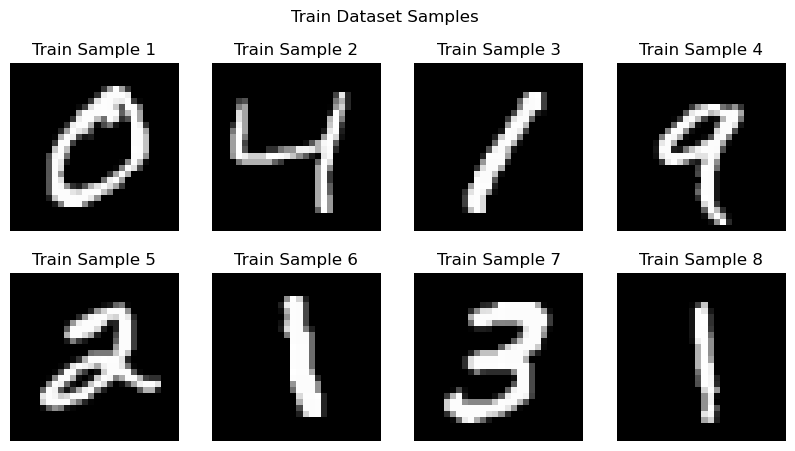

In [256]:
def plot_train_dataset():
    samples = [train_dataset.data[i] for i in range(8)]
    samples = torch.stack(samples)
    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(samples[i].squeeze(), cmap='gray')
        plt.title(f"Train Sample {i + 1}")
        plt.axis('off')
    plt.suptitle("Train Dataset Samples")
    plt.show()
    plt.close()

plot_train_dataset()

The image of the anomalies shows 5.



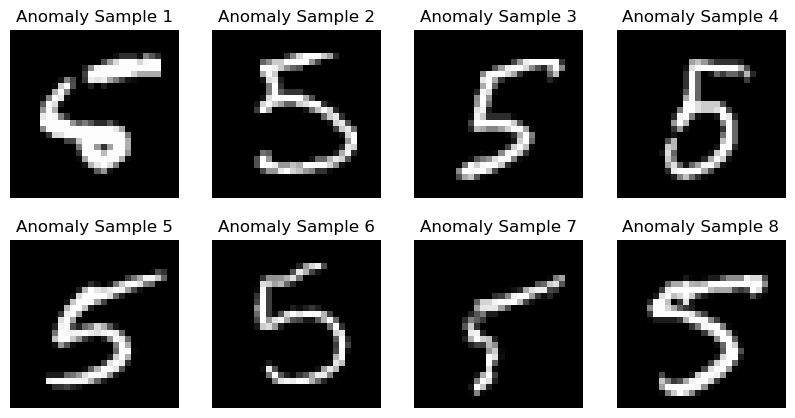

In [257]:
def plot_anomaly_dataset():
    samples = [anomaly_dataset.data[i] for i in range(8)]
    samples = torch.stack(samples)

    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(samples[i].squeeze(), cmap='gray')
        plt.title(f"Anomaly Sample {i + 1}")
        plt.axis('off')
    plt.show()
    plt.suptitle("Anomaly Dataset Samples")
    plt.close()

plot_anomaly_dataset()

## Task 1. Model

Implement the reparameterize method which performs the reparameterization to sample from a Gaussian distribution. Instead of sampling directly from a normal distribution N(mu, sigma^2),   this method samples from a standard normal distribution N(0,1) and transforms  it using the mean (mu) and standard deviation (sigma) derived from logvar.

In [258]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """
        Args:
            mu (torch.Tensor): The mean of the latent Gaussian distribution. Shape: (batch_size, latent_dim).
            logvar (torch.Tensor): The logarithm of the variance of the latent Gaussian distribution. Shape: (batch_size, latent_dim).

        Returns:
            torch.Tensor: A sampled latent variable tensor of shape (batch_size, latent_dim).
        """
        # YOUR CODE HERE
        eps = torch.randn_like(logvar)
        return mu + eps*torch.exp(0.5*logvar)
        #raise NotImplementedError()


    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [259]:
def test_reparameterize():

    latent_dim = 20
    batch_size = 5

    mu = torch.randn(batch_size, latent_dim)
    logvar = torch.randn(batch_size, latent_dim)
    vae = VAE()
    z = vae.reparameterize(mu, logvar)

    assert z.shape == mu.shape, f"Incorrect shape: expected {mu.shape}, got {z.shape}"
    assert z.requires_grad == mu.requires_grad, "Output tensor must retain requires_grad property"
    print("Success")

test_reparameterize()

Success


In [260]:
def test_reparameterize():
    torch.manual_seed(42)  
    model = VAE()
    batch_size = 10000
    latent_dim = 20
    mu = torch.zeros(batch_size, latent_dim)
    logvar = torch.zeros(batch_size, latent_dim)  
    z = model.reparameterize(mu, logvar)
    empirical_mean = z.mean(dim=0)
    empirical_std = z.std(dim=0)
    assert torch.allclose(empirical_mean, torch.zeros(latent_dim), atol=0.05), "Mean is off!"
    assert torch.allclose(empirical_std, torch.ones(latent_dim), atol=0.05), "Std dev is off!"
    print("Success")

test_reparameterize()

Success


## Task 2. Loss Function

Loss Function combines: Reconstruction Loss (BCE): Measures how well the VAE reconstructs the input.

KL Divergence (KLD): Regularizes the latent space to follow a standard normal distribution.

Implement the loss_function which computes the Variational Autoencoder (VAE) loss, which consists of two components:
      1. Reconstruction Loss (Binary Cross-Entropy) - Measures how well the reconstructed output matches the input.
      2. Kullback-Leibler Divergence (KLD) - Regularizes the latent space by ensuring it follows a standard normal distribution.


In [261]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    """
      Args:
          recon_x (torch.Tensor): Reconstructed output from the decoder, of shape (batch_size, 784).
          x (torch.Tensor): Original input data, of shape (batch_size, 1, 28, 28).
          mu (torch.Tensor): Mean of the latent distribution, of shape (batch_size, latent_dim).
          logvar (torch.Tensor): Log-variance of the latent distribution, of shape (batch_size, latent_dim).

      Returns:
          torch.Tensor: The total VAE loss, computed as BCE + KLD.
      """
    # YOUR CODE HERE
    x = x.reshape(x.shape[0], -1)
    epsilon = 1e-8
    BCE = -torch.sum(x * torch.log(recon_x + epsilon) + (1 - x) * torch.log(1 - recon_x + epsilon))
    #BCE = F.binary_cross_entropy(recon_x, x.reshape(x.shape[0], -1), reduction='sum')
    KLD = 0.5*torch.sum(torch.exp(logvar) + mu**2 - 1 - logvar)
    #raise NotImplementedError()

    return BCE + KLD


In [262]:
def test_loss_function():
    batch_size = 4
    latent_dim = 20
    x = torch.rand(batch_size, 1, 28, 28)
    recon_x = torch.rand(batch_size, 784)
    mu = torch.zeros(batch_size, latent_dim)
    logvar = torch.zeros(batch_size, latent_dim)
    loss = loss_function(recon_x, x, mu, logvar)
    assert isinstance(loss, torch.Tensor), "Loss should be a PyTorch tensor"
    assert loss.shape == torch.Size([]), f"Loss should be a scalar tensor, but got shape {loss.shape}"
    assert loss.item() >= 0, "Loss should be non-negative"
    print("Success")

test_loss_function()

Success


In [263]:
def test_loss_function():
    x = torch.zeros(2, 1, 28, 28)
    x[0] = 1.0 
    recon_x = torch.full((2, 784), 0.5)  
    mu = torch.zeros(2, 5)             
    logvar = torch.zeros(2, 5)          
    loss = loss_function(recon_x, x, mu, logvar)
    bce_expected = 2 * 784 * F.binary_cross_entropy(torch.full((1,), 0.5), torch.full((1,), 1.0), reduction='sum').item()
    kld_expected = 0.0
    expected = torch.tensor(bce_expected + kld_expected)
    print('loss:', loss.item())
    print('expected:', expected.item())
    assert torch.allclose(loss, expected, atol=1e-2), "VAE loss does not match expected value."
    print('Success')

test_loss_function()

loss: 1086.85498046875
expected: 1086.854736328125
Success


## Training and Anomaly Evaluation Function

In [264]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, target, batch_idx in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

def anomaly(epoch):
    model.eval()
    anomaly_loss = 0
    with torch.no_grad():
        for data, target, batch_idx in tqdm(anomaly_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            anomaly_loss += loss_function(recon_batch, data, mu, logvar).item()

    anomaly_loss /= len(anomaly_loader.dataset)
    print('====> anomaly set loss: {:.4f}'.format(anomaly_loss))

    return - anomaly_loss


Using auc value evaluate the model’s ability to distinguish between normal and anomalous data.

In [265]:
def auc():
    y_true = np.concatenate([np.zeros(len(train_dataset)), np.ones(len(anomaly_dataset))])
    y_score = []
    model.eval()
    with torch.no_grad():
        for data, target, batch_idx in tqdm(all_train_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            train_score_loss = loss_function(recon_batch, data, mu, logvar)
            train_score_loss = train_score_loss.cpu()
            y_score.append(np.round(train_score_loss, 1).detach().numpy())
        for data, target, batch_idx in tqdm(all_anomaly_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            anomaly_score_loss = loss_function(recon_batch, data, mu, logvar)
            anomaly_score_loss = anomaly_score_loss.cpu()
            y_score.append(np.round(anomaly_score_loss, 1).detach().numpy())

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.auc(fpr, tpr)

    return auc

## Task 3. Training Loop

In [266]:
device = torch.device("cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [221]:
if not skip_training:
   
    epochs = 20
    # Train VAE
    for epoch in range(1, epochs + 1):
        # YOUR CODE HERE
        train(epoch)
        anomaly(epoch)
        #raise NotImplementedError()
    auc = auc()
    print("AUC:" + str(np.round(auc, 2)))

100%|██████████| 7/7 [00:00<00:00, 300.89it/s]


====> anomaly set loss: 165.6623


100%|██████████| 7/7 [00:00<00:00, 259.61it/s]


====> anomaly set loss: 153.2989


100%|██████████| 7/7 [00:00<00:00, 302.62it/s]


====> anomaly set loss: 144.0231


100%|██████████| 7/7 [00:00<00:00, 304.12it/s]


====> anomaly set loss: 140.6244


100%|██████████| 7/7 [00:00<00:00, 303.74it/s]


====> anomaly set loss: 139.0813


100%|██████████| 7/7 [00:00<00:00, 303.19it/s]


====> anomaly set loss: 138.1931


100%|██████████| 7/7 [00:00<00:00, 285.08it/s]


====> anomaly set loss: 136.2768


100%|██████████| 7/7 [00:00<00:00, 302.81it/s]


====> anomaly set loss: 136.2508


100%|██████████| 7/7 [00:00<00:00, 296.76it/s]


====> anomaly set loss: 136.0258


100%|██████████| 7/7 [00:00<00:00, 301.28it/s]


====> anomaly set loss: 134.7425


100%|██████████| 7/7 [00:00<00:00, 285.10it/s]


====> anomaly set loss: 136.3791


100%|██████████| 7/7 [00:00<00:00, 275.78it/s]


====> anomaly set loss: 134.8820


100%|██████████| 7/7 [00:00<00:00, 300.12it/s]


====> anomaly set loss: 133.6242


100%|██████████| 7/7 [00:00<00:00, 295.52it/s]


====> anomaly set loss: 133.9145


100%|██████████| 7/7 [00:00<00:00, 272.66it/s]


====> anomaly set loss: 134.2158


100%|██████████| 7/7 [00:00<00:00, 238.89it/s]


====> anomaly set loss: 133.6232


100%|██████████| 7/7 [00:00<00:00, 302.52it/s]


====> anomaly set loss: 133.8360


100%|██████████| 7/7 [00:00<00:00, 304.29it/s]


====> anomaly set loss: 133.5984


100%|██████████| 7/7 [00:00<00:00, 267.72it/s]


====> anomaly set loss: 134.3571


100%|██████████| 7/7 [00:00<00:00, 303.21it/s]


====> anomaly set loss: 133.5232


100%|██████████| 892/892 [00:00<00:00, 2390.95it/s]


AUC:0.83


In [222]:
if not skip_training:
    tools.save_model(model, 'model.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to model.pth.


In [267]:
if skip_training:
    model = VAE().to(device)
    tools.load_model(model, 'model.pth', device)

Model loaded from model.pth.


Q: What is the obtained AUC value for the trained model?

1) 0.83

2) 0.05

3) 0.23

4) 0.55

In [268]:
a_1d = None # TASK: Replace None with your answer (1, 2, 3, 4)

# YOUR CODE HERE
a_1d = 1
#raise NotImplementedError()

In [269]:
# Here is a hiddent test


## PCA of bottleneck layer vectors

The model's hidden (bottleneck) layer generates latent representations of the input data. These vectors contain compressed knowledge of the inputs. Below we apply PCA to extract the principal components of these latent vectors and visualize their distribution.


 There is a little overlap between normal  and outlier data points.

It might take a few minutes to run this cell.

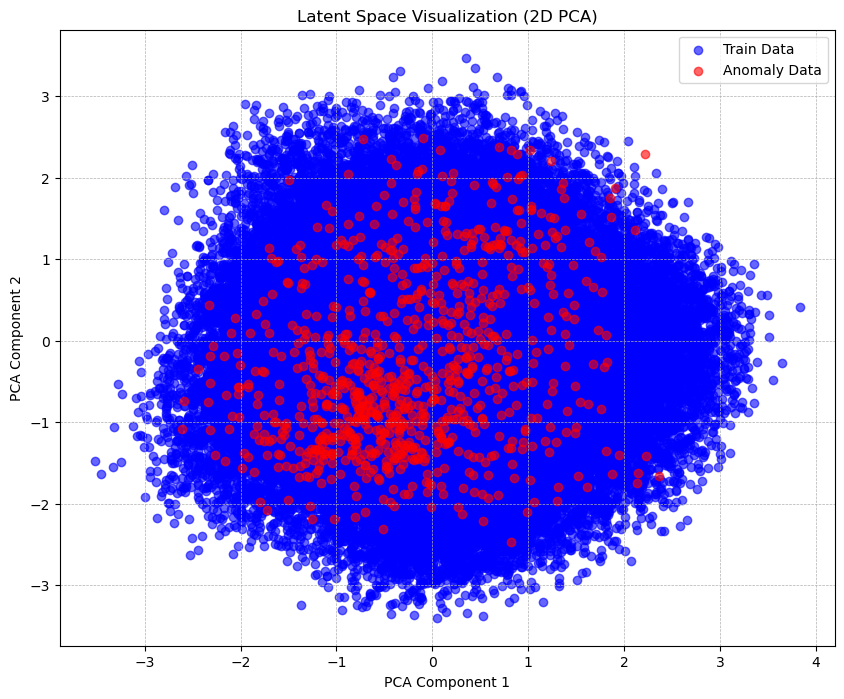

In [270]:
def extract_latent_representations(loader):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for data, _, _ in loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latent_vectors.append(mu.cpu())
    return torch.cat(latent_vectors)

train_latent = extract_latent_representations(all_train_loader)
anomaly_latent = extract_latent_representations(all_anomaly_loader)
latent_vectors = torch.cat([train_latent, anomaly_latent]).numpy()
labels = np.concatenate([np.zeros(len(train_latent)), np.ones(len(anomaly_latent))])
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)
plt.figure(figsize=(10, 8))
train_mask = labels == 0
anomaly_mask = labels == 1
plt.scatter(latent_2d[train_mask, 0], latent_2d[train_mask, 1], c='blue', label='Train Data', alpha=0.6)
plt.scatter(latent_2d[anomaly_mask, 0], latent_2d[anomaly_mask, 1], c='red', label='Anomaly Data', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Space Visualization (2D PCA)')
plt.legend()  
plt.grid(True, linestyle="--", linewidth=0.5)
plt.savefig('./latent_space.png')
plt.show()
plt.close()

## Task 4 . Evaluation on  Reconstruction Error

Compute the reconstruction error for a given input batch using a trained VAE model. The reconstruction error is measured using Binary Cross-Entropy (BCE) loss between the original input `x` and its reconstruction `x_recon`. The loss is computed per data point and summed over all dimensions.

When computing loss, check the correct choice for the reduction argument to retain per-sample loss values.
The loss is summed over all input dimensions to obtain a scalar error per sample.

In [271]:
def compute_reconstruction_error(model, x):
    """
    Args:
    model : torch.nn.Module
        The trained Variational Autoencoder (VAE) model.
    x : torch.Tensor
        Input tensor of shape (batch_size, 1, 28, 28) representing MNIST images.

    Returns:
    numpy.ndarray
        A NumPy array containing the reconstruction error for each input in `x`.

    """
    model.eval()
    with torch.no_grad():
        x_recon, _, _ = model(x.to(device))
        # YOUR CODE HERE
        recon_loss = F.binary_cross_entropy(x_recon, x.reshape(x.shape[0], -1), reduction='none')
        recon_loss = torch.sum(recon_loss, dim=1)
        
        #raise NotImplementedError()

    return recon_loss.cpu().numpy()

In [272]:
def test_compute_reconstruction_error():
    batch_size = 4
    image_size = (1, 28, 28)
    dummy_model = VAE().to(device)
    dummy_input = torch.rand(batch_size, *image_size).to(device)
    recon_errors = compute_reconstruction_error(dummy_model, dummy_input)

    assert isinstance(recon_errors, np.ndarray), "Output should be a NumPy array"
    assert recon_errors.shape == (batch_size,), f"Expected shape ({batch_size},), but got {recon_errors.shape}"
    assert np.all(recon_errors >= 0), "Reconstruction error should be non-negative"
    print("Success")

test_compute_reconstruction_error()

Success


In [273]:
def test_compute_reconstruction_error():

    model = VAE().to(device)
    with torch.no_grad():
        for param in model.parameters():
            param.zero_()
        model.fc4.bias.fill_(np.log(0.5 / (1 - 0.5))) 
    x = torch.zeros(2, 1, 28, 28)
    x[1] = 1.0 
    x = x.to(device)
    errors = compute_reconstruction_error(model, x)
    expected_error_0 = 784 * F.binary_cross_entropy(torch.tensor([0.5]), torch.tensor([0.0]), reduction='sum').item()
    expected_error_1 = 784 * F.binary_cross_entropy(torch.tensor([0.5]), torch.tensor([1.0]), reduction='sum').item()
    expected = np.array([expected_error_0, expected_error_1])
    print("Computed errors:", errors)
    print("Expected errors:", expected)
    assert np.allclose(errors, expected, atol=1e-2), "Reconstruction error test failed"
    print("Success")

test_compute_reconstruction_error()

Computed errors: [543.4275 543.4275]
Expected errors: [543.42739105 543.42739105]
Success


In [274]:
train_normal_data = []
for  data, _, _ in tqdm(train_loader):
    train_normal_data.append(data)
    if len(train_normal_data) >= 2000 // 128:  # Stop after collecting 2000 samples
        break
train_normal_data = torch.cat(train_normal_data)[:2000]  # Take the first 2000 samples

test_normal_data = []
for data, _, _ in tqdm(test_loader):
    test_normal_data.append(data)
    if len(test_normal_data) >= 2000 // 128:
        break
test_normal_data = torch.cat(test_normal_data)[:2000]

anomaly_data = []
for data, _, _ in tqdm(anomaly_loader):
    anomaly_data.append(data)
    if len(anomaly_data) >= 2000 // 128:
        break
anomaly_data = torch.cat(anomaly_data)[:2000]

100%|██████████| 7/7 [00:00<00:00, 572.48it/s]


In [275]:
train_normal_recon_loss = compute_reconstruction_error(model, train_normal_data)
test_normal_recon_loss = compute_reconstruction_error(model, test_normal_data)
anomaly_recon_loss = compute_reconstruction_error(model, anomaly_data)

Next, we plot the reconstruction error for train normal and anomaly data:



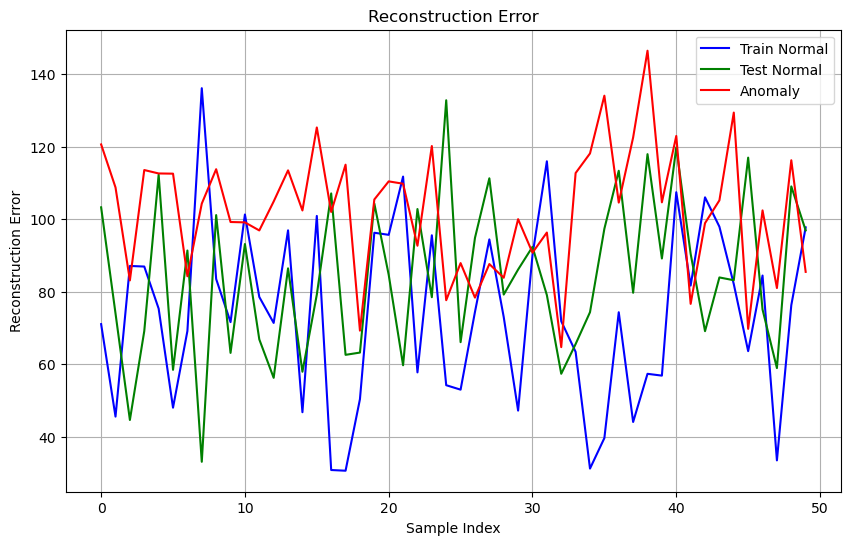

In [276]:
plt.figure(figsize=(10, 6))
plt.plot(train_normal_recon_loss[:50], label='Train Normal', color='blue')
plt.plot(test_normal_recon_loss[:50], label='Test Normal', color='green')

plt.plot(anomaly_recon_loss[:50], label='Anomaly', color='red')
plt.title('Reconstruction Error')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.savefig('./reconstruction_error.png')
plt.show()

Further statistical analysis demonstrates that the average reconstruction loss for anomalies (about 104) and is higher than that of the normal data (about 78):

In [277]:
train_normal_stats = stats.describe(train_normal_recon_loss)
anomaly_stats = stats.describe(anomaly_recon_loss)

print("Descriptive Statistics for Normal Data Reconstruction Errors:")
print(train_normal_stats)

print("\nDescriptive Statistics for Anomaly Data Reconstruction Errors:")
print(anomaly_stats)

Descriptive Statistics for Normal Data Reconstruction Errors:
DescribeResult(nobs=1920, minmax=(25.924057, 176.03897), mean=77.9575, variance=517.7395656917666, skewness=0.25656991335367285, kurtosis=0.3952644862612731)

Descriptive Statistics for Anomaly Data Reconstruction Errors:
DescribeResult(nobs=892, minmax=(54.15403, 171.7554), mean=104.8572, variance=350.2238348929837, skewness=0.34710865771366806, kurtosis=0.23678116824135653)


In [278]:
# Calculate average reconstruction loss
avg_normal_recon_loss = np.mean(train_normal_recon_loss)
avg_anomaly_recon_loss = np.mean(anomaly_recon_loss)

print(f'\nAverage Reconstruction Loss for Normal Data: {avg_normal_recon_loss:.2f}')
print(f'Average Reconstruction Loss for Anomaly Data: {avg_anomaly_recon_loss:.2f}')
print(f'Difference: {avg_anomaly_recon_loss - avg_normal_recon_loss:.2f}')


Average Reconstruction Loss for Normal Data: 77.96
Average Reconstruction Loss for Anomaly Data: 104.86
Difference: 26.90


## Evaluate the model performance

To evaluate the ability of the model to differentiate between normal data and anomalies, we set a threshold: when the reconstruction error is higher, we assign it as an anomaly, and when it’s lower, we assign it as normal data. To find the threshold, let’s look at statistical properties of the reconstruction error:

In [279]:
normal_percentile_1 = np.percentile(train_normal_recon_loss, 1)
normal_percentile_99 = np.percentile(train_normal_recon_loss, 99)

anomaly_percentile_4 = np.percentile(anomaly_recon_loss, 4)
anomaly_percentile_99 = np.percentile(anomaly_recon_loss, 99)

print(f'\n1st and 99th Percentile of Normal Reconstruction Loss: {normal_percentile_1}, {normal_percentile_99}')
print(f'4th and 99th Percentile of Anomaly Reconstruction Loss: {anomaly_percentile_4}, {anomaly_percentile_99}')


1st and 99th Percentile of Normal Reconstruction Loss: 31.278900108337403, 137.78065277099606
4th and 99th Percentile of Anomaly Reconstruction Loss: 74.77180206298829, 154.1840675354004


In [280]:
threshold = np.ceil(np.percentile(train_normal_recon_loss, 99))
print(threshold)

138.0


In [281]:
threshold=80

In [282]:
combined_test_recon_loss = np.concatenate([test_normal_recon_loss, anomaly_recon_loss])

In [283]:
combined_test_y_pred = np.array([1 if x>threshold else 0 for x in combined_test_recon_loss])

In [284]:
print("Normal samples:", sum(combined_test_y_pred == 0))
print("Anomaly samples:", sum(combined_test_y_pred == 1))

Normal samples: 1104
Anomaly samples: 1708


In [285]:
binary_labels = np.concatenate([
    np.zeros(len(test_normal_recon_loss)),  # Label 0 for normal data
    np.ones(len(anomaly_recon_loss))        # Label 1 for anomalies
])

In [286]:
accuracy = accuracy_score(binary_labels, combined_test_y_pred)
print('Accuracy: %f' % accuracy, '\n')
precision = precision_score(binary_labels, combined_test_y_pred)
print('Precision: %f' % precision, '\n')
recall = recall_score(binary_labels, combined_test_y_pred)
print('Recall: %f' % recall, '\n')
f1 = f1_score(binary_labels, combined_test_y_pred)
print('F1 score: %f' % f1, '\n')

auc = roc_auc_score(binary_labels, combined_test_y_pred)
print('ROC AUC: %f' % auc, '\n')
matrix = confusion_matrix(binary_labels, combined_test_y_pred)
print('Confusion Matrix:', '\n', matrix, '\n')

Accuracy: 0.660028 

Precision: 0.481265 

Recall: 0.921525 

F1 score: 0.632308 

ROC AUC: 0.730033 

Confusion Matrix: 
 [[1034  886]
 [  70  822]] 

